In [1]:
from sklearn.datasets import fetch_openml
import os

os.environ["http_proxy"] = "http://127.0.0.1:3128"
os.environ["https_proxy"] = "http://127.0.0.1:3128"

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
mnist["details"]

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'minio_url': 'http://openml1.win.tue.nl/dataset554/dataset_554.pq',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
some_digit = X[0]
some_digit_imgarr = some_digit.reshape(28, 28)

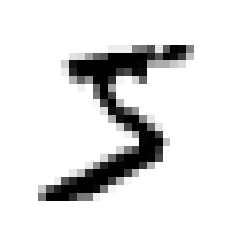

In [7]:
plt.imshow(some_digit_imgarr, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
import numpy as np

y = y.astype(np.uint8)
y[0]

5

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# train a binary classifier
# classify only 'is a 5' vs 'is not a 5'

y_test_5 = (y_test == 5)
y_train_5 = (y_train == 5)

In [11]:
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator

class Never5(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf= Never5()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [16]:
# confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [19]:
y_train_never = cross_val_predict(never_5_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_never)

array([[54579,     0],
       [ 5421,     0]], dtype=int64)

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
# F1 score (harmonic mean of precision and recall)

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

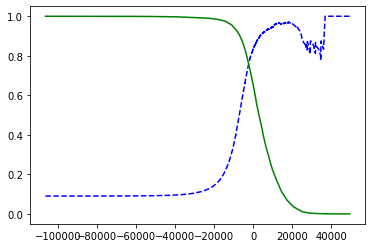

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, threshholds = roc_curve(y_train_5, y_scores)

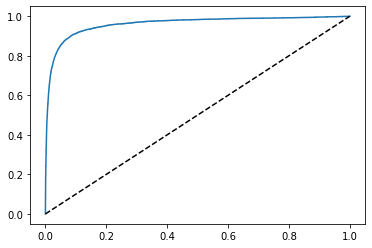

In [27]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, label=None)
    plt.plot([0,1], [0,1], "k--")

plot_roc_curve(fpr, tpr)
plt.show()    

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

y_probas_rf = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [30]:
y_scores_rf = y_probas_rf[:, 1]

fpr_rf, tpr_rf, threshold = roc_curve(y_train_5, y_scores_rf)

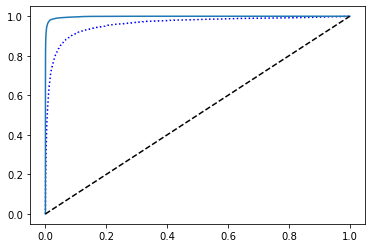

In [31]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_rf, tpr_rf)
plt.show()

In [32]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [33]:
sgd_clf.fit(X_train, y_train) # all y's 0 ... 9
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
np.argmax(some_digit_scores)

3

In [39]:
from sklearn.multiclass import OneVsOneClassifier
mc_ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

mc_ovo_clf.fit(X_train, y_train)
mc_ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
len(mc_ovo_clf.estimators_)

45

In [41]:
rf_clf.fit(X_train, y_train)
rf_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
rf_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [64]:
cross_val_score(mc_ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91545, 0.9131 , 0.92045])

In [65]:
cross_val_score(rf_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)

array([0.9713 , 0.9669 , 0.96785])

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [61]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

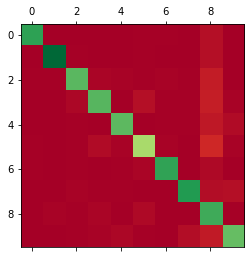

In [72]:


plt.matshow(conf_mx, cmap=plt.cm.RdYlGn)

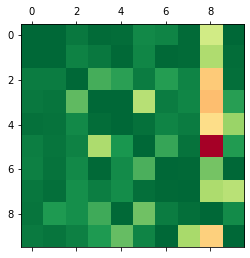

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.RdYlGn_r)
plt.show()